In [2]:
#imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, regularizers
from tensorflow import keras
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

#### Load and Preprocess the data:

In [3]:
# Load the datasets
uk_data = pd.read_csv('/mnt/c/Users/anast/Documents/GitHub/Diploma-Thesis/data/dataset.csv')
adni_data = pd.read_csv('/mnt/c/Users/anast/Documents/GitHub/Diploma-Thesis/data/real_data.csv')
uk_data['Sex']= uk_data['Sex'].replace(['M', 'F'],['Male', 'Female'])
adni_data['Sex']= adni_data['Sex'].replace(['M', 'F'],['Male', 'Female'])
# Column to split by
split_column = 'DX_binary'

# Get unique values in the column
unique_values = adni_data[split_column].unique()

# Create a dictionary to hold sub-DataFrames
sub_dfs = {value: adni_data[adni_data[split_column] == value] for value in unique_values}

# Now sub_dfs is a dictionary where keys are unique values from the column
# and values are DataFrames corresponding to each unique value

cn_df = sub_dfs['CN']
ad_df = sub_dfs['AD']
mci_df = sub_dfs['MCI']

In [4]:
uk_age = uk_data['Age']

##### DLICV Correction:

###### UK-Biobank:

In [5]:
uk_data = uk_data.drop(['ID','Age'], axis=1)

Text(0.5, 29.140624999999986, 'Intracranial Volume')

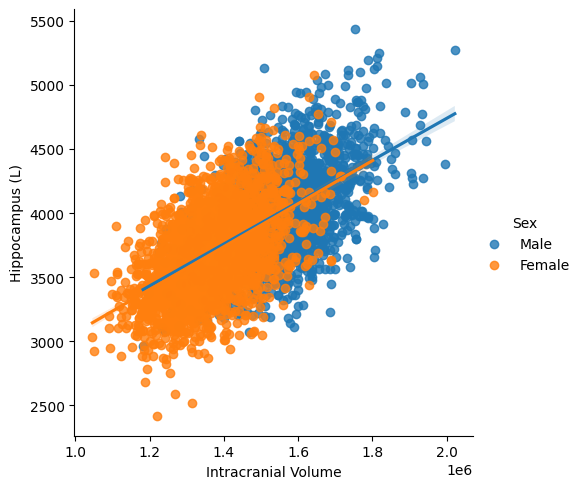

In [6]:
sns.lmplot(data=uk_data , x='DLICV_baseline', y='MUSE_Volume_48', hue='Sex')
plt.ylabel('Hippocampus (L)')
plt.xlabel('Intracranial Volume')

In [7]:
# Step 1: Split the uk

# Assume 'predictor_column' is the column you want to use as the predictor (regressor)
uk_corrected = uk_data.copy()
predictor_column = 'DLICV_baseline'
specific_column = 'Sex'
target_columns = [col for col in uk_data.columns if col != predictor_column and col != specific_column]

X = uk_data[[predictor_column]]
y = uk_data[target_columns]

# Step 2: Create and Train the Model
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Create a linear regression model for each target variable
models = {}
for target in target_columns:
    model = LinearRegression()
    model.fit(X_train, y_train[target])
    models[target] = model

# Step 3: replace the values with residuals values
for target, model in models.items():
    y_pred = model.predict(X_test)
    uk_corrected[target] = y_test[target] - y_pred

# Step 4: Interpret the Results
# Interpret the coefficients of the linear regression model
for target, model in models.items():
    print(f"Target Variable: {target}")
    print(f"Coefficient: {model.coef_[0]}")
    print(f"Intercept: {model.intercept_}")
    print()

Target Variable: MUSE_Volume_105
Coefficient: 0.0010555016531011037
Intercept: 88.36364026049182

Target Variable: MUSE_Volume_137
Coefficient: 0.0014899375272042123
Intercept: 149.43552137589813

Target Variable: MUSE_Volume_147
Coefficient: 0.0027641374893602496
Intercept: 348.5810793041983

Target Variable: MUSE_Volume_179
Coefficient: 0.0016149784986821123
Intercept: 735.6651880469035

Target Variable: MUSE_Volume_104
Coefficient: 0.0014045521440301369
Intercept: -53.59990272238474

Target Variable: MUSE_Volume_136
Coefficient: 0.0013733059100779926
Intercept: 132.72984529168502

Target Variable: MUSE_Volume_146
Coefficient: 0.0023174306160772644
Intercept: 962.9519274378949

Target Variable: MUSE_Volume_178
Coefficient: 0.0018500890583046828
Intercept: 525.3713114963116

Target Variable: MUSE_Volume_103
Coefficient: 0.0019230616035996531
Intercept: 1453.7113480242097

Target Variable: MUSE_Volume_173
Coefficient: 0.0009238429561213586
Intercept: 889.4053682974968

Target Variable:

In [8]:
#shifting values
min_value = np.zeros(len(target_columns))
for i, target in enumerate(target_columns):
    min_value[i] = uk_corrected[target].min()
    if min_value[i] < 0:
        uk_corrected.loc[:, target] = uk_corrected[target] - min_value[i]

In [9]:
uk_corrected = uk_corrected.dropna()

Text(0.5, 29.140624999999986, 'Intracranial Volume')

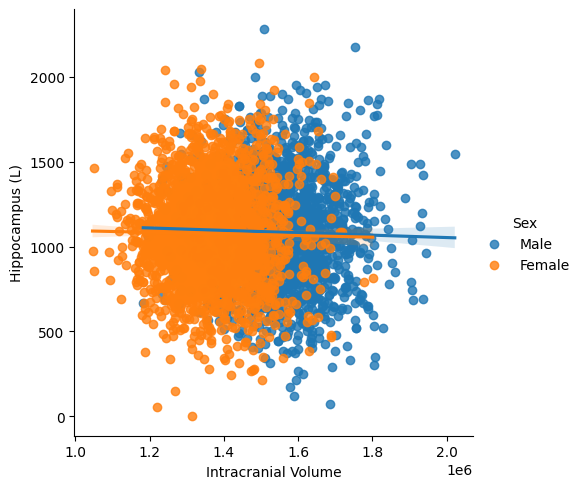

In [10]:
sns.lmplot(data=uk_corrected, x='DLICV_baseline', y='MUSE_Volume_48', hue='Sex')
plt.ylabel('Hippocampus (L)')
plt.xlabel('Intracranial Volume')

##### ADNI:

In [11]:
cn_df = cn_df.drop(['ID', 'DX_binary'], axis=1)
mci_df = mci_df.drop(['ID', 'DX_binary'], axis=1)
ad_df = ad_df.drop(['ID', 'DX_binary'], axis=1)

Text(0.5, 29.140624999999986, 'Intracranial Volume')

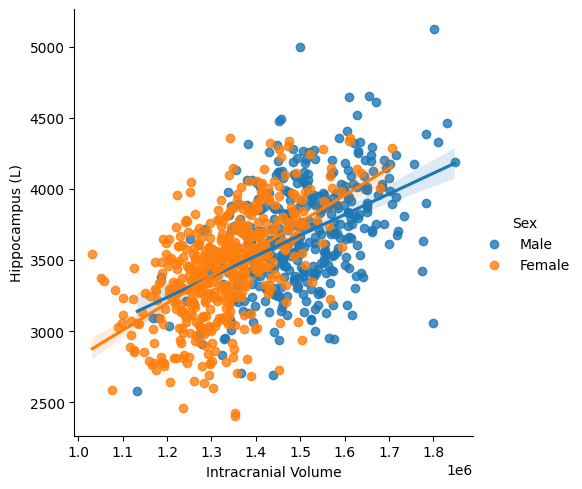

In [12]:
sns.lmplot(data=cn_df, x='DLICV_baseline', y='MUSE_Volume_48', hue='Sex')
plt.ylabel('Hippocampus (L)')
plt.xlabel('Intracranial Volume')

Text(0.5, 28.999999999999986, 'Age (years)')

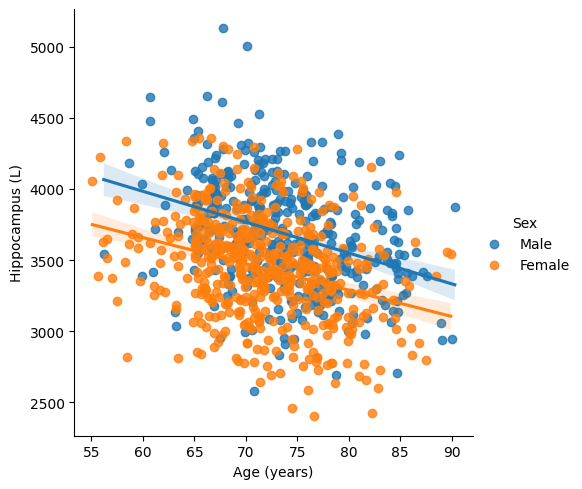

In [13]:
sns.lmplot(data=cn_df, x='Age', y='MUSE_Volume_48', hue='Sex')
plt.ylabel('Hippocampus (L)')
plt.xlabel('Age (years)')

In [14]:
# Assume 'cn_df' is your DataFrame
# Drop any rows with NaNs
cn_df = cn_df.dropna()

# Copy the DataFrame to store the corrected values
cn_df_corrected = cn_df.copy()

# Define predictor and target columns
predictor_columns = ['DLICV_baseline', 'Age']
specific_column = 'Sex'
target_columns = [col for col in cn_df.columns if col not in predictor_columns and col != specific_column]

# Extract the predictors and targets
X = cn_df[predictor_columns]
y = cn_df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)


# Initialize a dictionary to store models for each target variable
models = {}

# Create and train a linear regression model for each target variable
for target in target_columns:
    model = LinearRegression()
    model.fit(X_train, y_train[target])
    models[target] = model

# Replace the target values with the residuals (corrected values)
for target, model in models.items():
    y_pred = model.predict(X_test)
    cn_df_corrected[target] = y_test[target] - y_pred

# Print the coefficients and intercepts of the linear regression models
for target, model in models.items():
    print(f"Target Variable: {target}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print()

Target Variable: MUSE_Volume_105
Coefficients: [ 8.44741998e-04 -9.67947601e+00]
Intercept: 1002.6824187265022

Target Variable: MUSE_Volume_137
Coefficients: [ 9.92922489e-04 -6.67238222e+00]
Intercept: 1082.9445275633132

Target Variable: MUSE_Volume_147
Coefficients: [0.00261295 1.58242032]
Intercept: 614.1782635217728

Target Variable: MUSE_Volume_179
Coefficients: [ 1.50072578e-03 -6.00001169e+00]
Intercept: 1150.4597730793012

Target Variable: MUSE_Volume_104
Coefficients: [ 0.00088264 -0.73880407]
Intercept: 373.69125464638637

Target Variable: MUSE_Volume_136
Coefficients: [ 0.00156379 -1.54006587]
Intercept: 19.759506869962024

Target Variable: MUSE_Volume_146
Coefficients: [ 0.00166698 -0.43800661]
Intercept: 1707.0399469550011

Target Variable: MUSE_Volume_178
Coefficients: [ 1.78163365e-03 -1.15557290e+01]
Intercept: 1404.8060977885443

Target Variable: MUSE_Volume_103
Coefficients: [ 1.71876695e-03 -1.57159481e+01]
Intercept: 2546.673895763393

Target Variable: MUSE_Volume

In [15]:
#shifting values
min_value = np.zeros(len(target_columns))
for i, target in enumerate(target_columns):
    min_value[i] = cn_df_corrected[target].min()
    if min_value[i] < 0:
        cn_df_corrected.loc[:, target] = cn_df_corrected[target] - min_value[i]

Text(0.5, 29.140624999999986, 'Intracranial Volume')

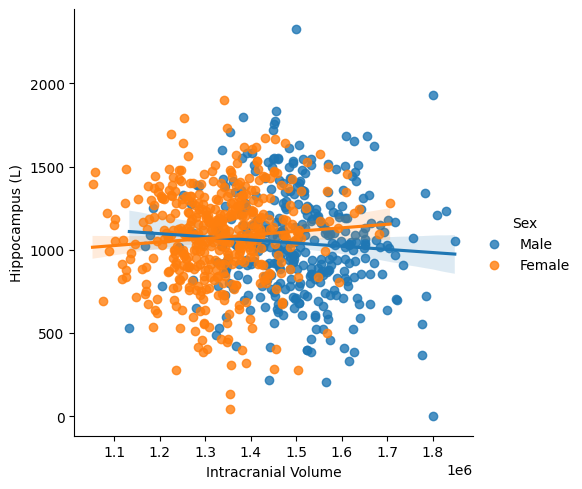

In [16]:
sns.lmplot(data=cn_df_corrected, x='DLICV_baseline', y='MUSE_Volume_48', hue='Sex')
plt.ylabel('Hippocampus (L)')
plt.xlabel('Intracranial Volume')

Text(0.5, 28.999999999999986, 'Age (years)')

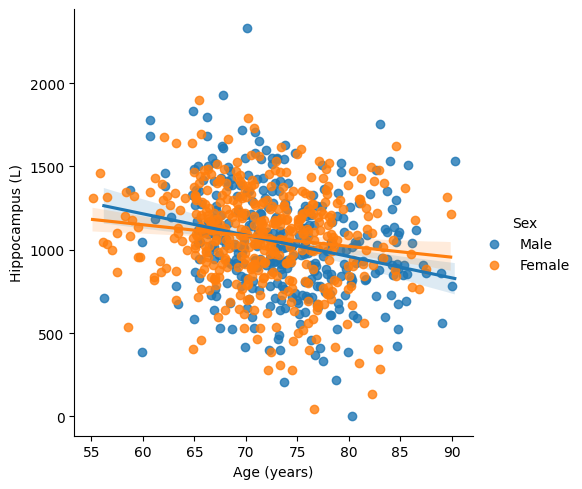

In [17]:
sns.lmplot(data=cn_df_corrected, x='Age', y='MUSE_Volume_48', hue='Sex')
plt.ylabel('Hippocampus (L)')
plt.xlabel('Age (years)')

In [18]:
mci_df = mci_df.dropna()

# Copy the DataFrame to store the corrected values
mci_df_corrected = mci_df.copy()

# Define predictor and target columns
predictor_columns = ['DLICV_baseline', 'Age']
specific_column = 'Sex'
target_columns = [col for col in mci_df.columns if col not in predictor_columns and col != specific_column]

# Extract the predictors and targets
X = mci_df[predictor_columns]
y = mci_df[target_columns]

# Replace the target values with the residuals (corrected values)
for target, model in models.items():
    y_pred = model.predict(X)
    mci_df_corrected[target] = y[target] - y_pred

# Print the coefficients and intercepts of the linear regression models
for target, model in models.items():
    print(f"Target Variable: {target}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print()

Target Variable: MUSE_Volume_105
Coefficients: [ 8.44741998e-04 -9.67947601e+00]
Intercept: 1002.6824187265022

Target Variable: MUSE_Volume_137
Coefficients: [ 9.92922489e-04 -6.67238222e+00]
Intercept: 1082.9445275633132

Target Variable: MUSE_Volume_147
Coefficients: [0.00261295 1.58242032]
Intercept: 614.1782635217728

Target Variable: MUSE_Volume_179
Coefficients: [ 1.50072578e-03 -6.00001169e+00]
Intercept: 1150.4597730793012

Target Variable: MUSE_Volume_104
Coefficients: [ 0.00088264 -0.73880407]
Intercept: 373.69125464638637

Target Variable: MUSE_Volume_136
Coefficients: [ 0.00156379 -1.54006587]
Intercept: 19.759506869962024

Target Variable: MUSE_Volume_146
Coefficients: [ 0.00166698 -0.43800661]
Intercept: 1707.0399469550011

Target Variable: MUSE_Volume_178
Coefficients: [ 1.78163365e-03 -1.15557290e+01]
Intercept: 1404.8060977885443

Target Variable: MUSE_Volume_103
Coefficients: [ 1.71876695e-03 -1.57159481e+01]
Intercept: 2546.673895763393

Target Variable: MUSE_Volume

In [19]:
#shifting values
for i, target in enumerate(target_columns):
    if min_value[i] < 0:
        mci_df_corrected.loc[:, target] = mci_df_corrected[target] - min_value[i]

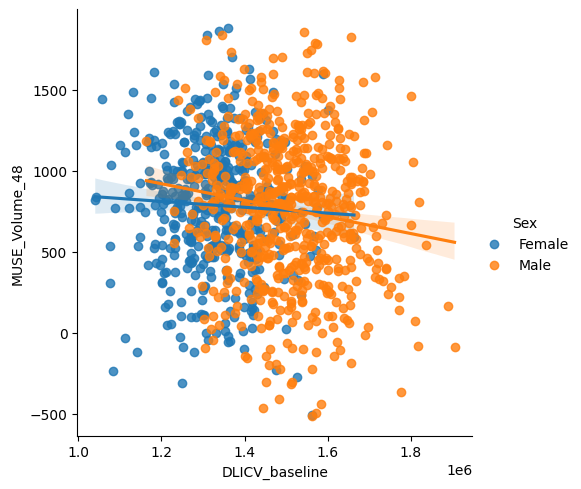

In [20]:
sns.lmplot(data=mci_df_corrected, x='DLICV_baseline', y='MUSE_Volume_48', hue='Sex')

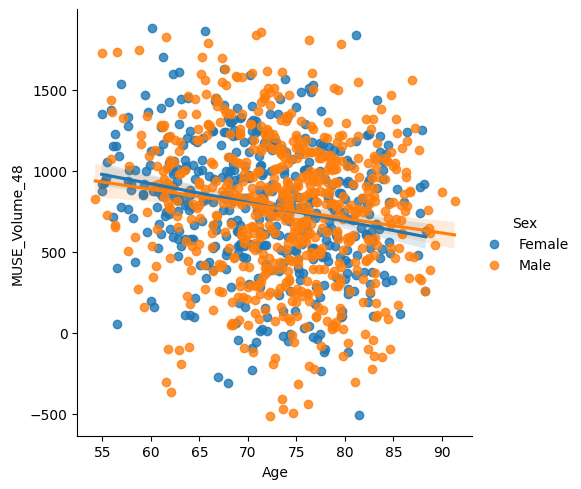

In [21]:
sns.lmplot(data=mci_df_corrected, x='Age', y='MUSE_Volume_48', hue='Sex')

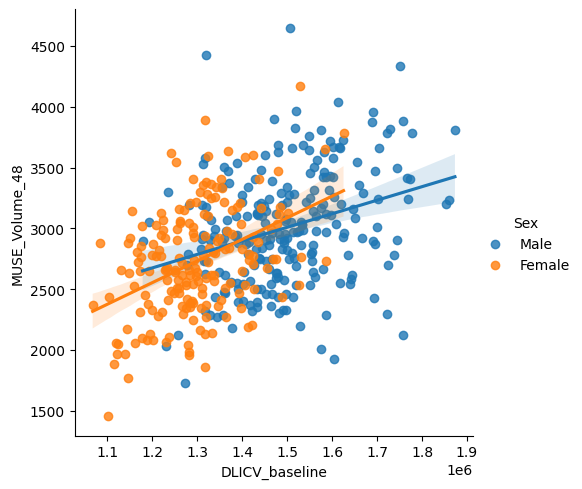

In [22]:
#ad_df
sns.lmplot(data=ad_df, x='DLICV_baseline', y='MUSE_Volume_48', hue='Sex')

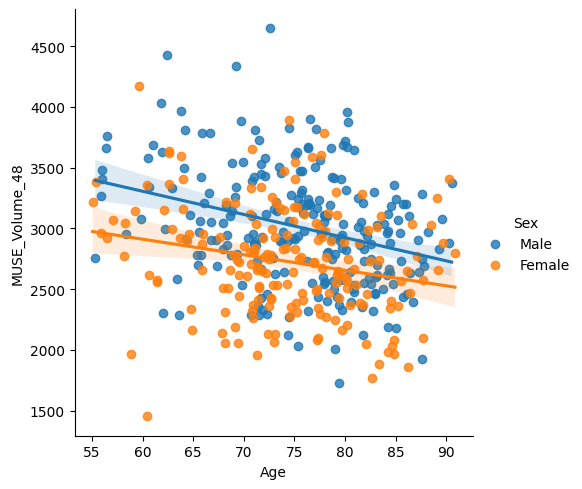

In [23]:
sns.lmplot(data=ad_df, x='Age', y='MUSE_Volume_48', hue='Sex')

In [24]:
ad_df = ad_df.dropna()

# Copy the DataFrame to store the corrected values
ad_df_corrected = ad_df.copy()

# Define predictor and target columns
predictor_columns = ['DLICV_baseline', 'Age']
specific_column = 'Sex'
target_columns = [col for col in ad_df.columns if col not in predictor_columns and col != specific_column]

# Extract the predictors and targets
X = ad_df[predictor_columns]
y = ad_df[target_columns]

# Replace the target values with the residuals (corrected values)
for target, model in models.items():
    y_pred = model.predict(X)
    ad_df_corrected[target] = y[target] - y_pred

# Print the coefficients and intercepts of the linear regression models
for target, model in models.items():
    print(f"Target Variable: {target}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print()

Target Variable: MUSE_Volume_105
Coefficients: [ 8.44741998e-04 -9.67947601e+00]
Intercept: 1002.6824187265022

Target Variable: MUSE_Volume_137
Coefficients: [ 9.92922489e-04 -6.67238222e+00]
Intercept: 1082.9445275633132

Target Variable: MUSE_Volume_147
Coefficients: [0.00261295 1.58242032]
Intercept: 614.1782635217728

Target Variable: MUSE_Volume_179
Coefficients: [ 1.50072578e-03 -6.00001169e+00]
Intercept: 1150.4597730793012

Target Variable: MUSE_Volume_104
Coefficients: [ 0.00088264 -0.73880407]
Intercept: 373.69125464638637

Target Variable: MUSE_Volume_136
Coefficients: [ 0.00156379 -1.54006587]
Intercept: 19.759506869962024

Target Variable: MUSE_Volume_146
Coefficients: [ 0.00166698 -0.43800661]
Intercept: 1707.0399469550011

Target Variable: MUSE_Volume_178
Coefficients: [ 1.78163365e-03 -1.15557290e+01]
Intercept: 1404.8060977885443

Target Variable: MUSE_Volume_103
Coefficients: [ 1.71876695e-03 -1.57159481e+01]
Intercept: 2546.673895763393

Target Variable: MUSE_Volume

In [25]:
#shifting values
for i, target in enumerate(target_columns):
    if min_value[i] < 0:
        ad_df_corrected.loc[:, target] = ad_df_corrected[target] - min_value[i]

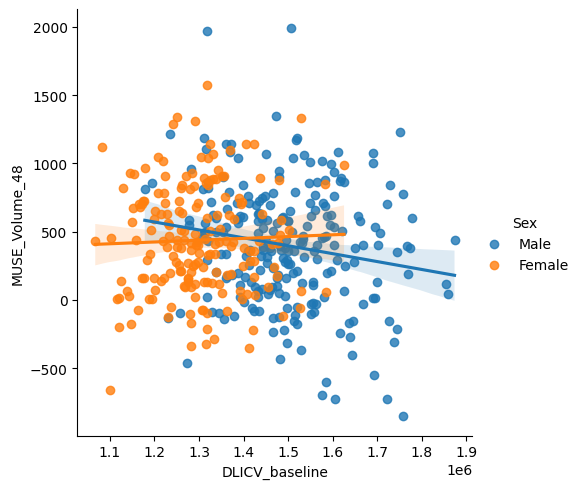

In [26]:
sns.lmplot(data=ad_df_corrected, x='DLICV_baseline', y='MUSE_Volume_48', hue='Sex')

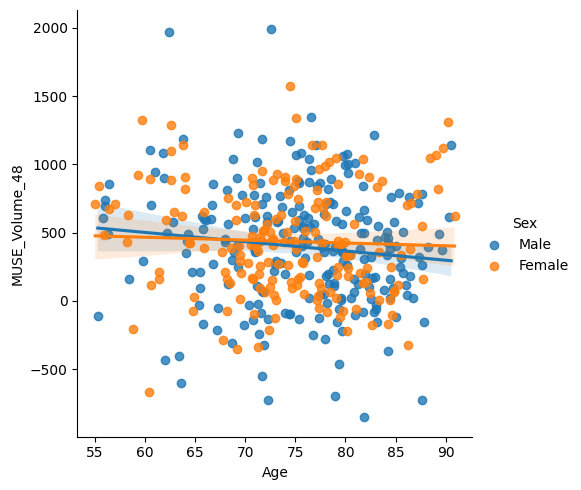

In [27]:
sns.lmplot(data=ad_df_corrected, x='Age', y='MUSE_Volume_48', hue='Sex')

##### end confounders correction

In [28]:
uk = uk_corrected.drop(columns=['Sex', 'DLICV_baseline'], axis=1)

In [59]:
cn_df_corrected['Diagnosis'] = 0
mci_df_corrected['Diagnosis'] = 1
ad_df_corrected['Diagnosis'] = 2

In [60]:
palette1 = {
    "CN": 'darkgreen',
    "MCI": 'darkblue',
    "AD": 'darkred'
}
palette = {
    0: 'darkgreen',
    1: 'darkblue',
    2: 'darkred'
}

##### diagrams standardization

In [44]:
adni = pd.concat([cn_df_corrected, mci_df_corrected, ad_df_corrected], axis=0)
adni = adni.dropna()
#adni = adni.drop(columns=['Sex', 'DLICV_baseline'], axis=1)

In [45]:
palette = {
    0: 'darkgreen',
    1: 'darkblue',
    2: 'darkred'
}

In [46]:
palette1 = {
    "CN": 'darkgreen',
    "MCI": 'darkblue',
    "AD": 'darkred'
}

Text(43.474323881172836, 0.5, 'Left Hippocampus')

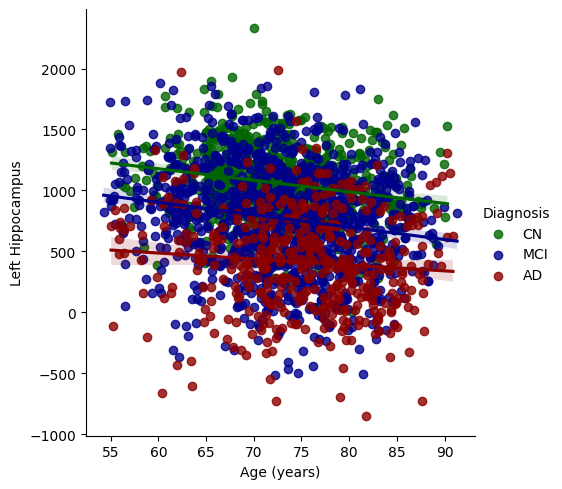

In [48]:
sns.lmplot(data=adni, x='Age', y='MUSE_Volume_48', hue='Diagnosis', palette=palette1)
plt.xlabel('Age (years)')
plt.ylabel('Left Hippocampus')

In [49]:
adni_age = adni['Age']
adni_diag = adni['Diagnosis']
adni = adni.drop(columns=['Age', 'Diagnosis'], axis=1)

In [50]:
scaler_uk  = StandardScaler()
#uk.dropna()
X_uk_scaled = scaler_uk.fit_transform(uk)

In [51]:
adni = adni.drop(columns=['Sex', 'DLICV_baseline'], axis=1)

In [52]:
col_list = adni.columns.tolist()
X_adni_scaled = scaler_uk.transform(adni)

In [53]:
scaled_adni = pd.DataFrame(X_adni_scaled, columns=col_list)
scaled_adni['Diagnosis'] = adni_diag
scaled_adni['Age'] = adni_age
scaled_adni

,MUSE_Volume_105,MUSE_Volume_137,MUSE_Volume_147,MUSE_Volume_179,MUSE_Volume_104,MUSE_Volume_136,MUSE_Volume_146,MUSE_Volume_178,MUSE_Volume_103,MUSE_Volume_173,...,MUSE_Volume_171,MUSE_Volume_116,MUSE_Volume_170,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,Diagnosis,Age
0,-4.761529,-1.351337,-2.369421,-1.867295,-0.126999,-1.929015,-1.694866,-2.793399,-1.748788,-0.533679,...,-1.658515,1.073848,-0.429304,0.369080,0.195458,-0.194427,-1.480810,-0.752238,CN,84.742505
1,-0.542047,0.331395,-1.042387,-0.585124,2.207498,-2.207670,0.555055,-2.015885,-3.222419,-3.641831,...,0.421358,0.482834,0.424853,-1.055425,-1.360123,-1.946609,-3.098742,-1.962921,NaN,NaN
2,-1.516132,-0.516820,-0.794193,-2.171100,1.357913,-1.418038,-1.609030,-2.094179,-1.716647,-2.674439,...,-1.281268,-0.312882,0.147261,0.067788,-0.407526,-0.876572,-1.174931,1.818449,CN,79.223340
3,-2.519559,-0.142103,-1.045426,-2.630644,0.260475,-1.314583,-1.071756,-1.805150,-1.917306,-2.006378,...,-1.729996,-1.302000,-2.357141,-0.504591,-0.693151,0.460052,-1.440507,0.026636,AD,77.447981
4,-3.345507,-0.381127,-2.562853,-0.989182,0.535839,-1.839535,-2.732642,-1.779771,-2.232208,-2.455202,...,-1.056573,0.502040,-0.893675,-1.771344,-1.847030,-1.270909,-1.506280,0.151639,CN,89.561670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,-2.051857,-0.684009,0.114160,-1.992182,-0.738904,-2.955980,-0.902918,-2.605121,-2.054587,-4.001309,...,-3.449223,0.272226,-2.197089,-1.430545,-1.009111,-1.613525,-0.928958,-0.610467,MCI,68.600000
2300,-0.110839,-1.905903,-0.706293,-1.348575,-0.106167,-1.428653,-0.870599,-2.765405,-1.986263,-4.043492,...,-1.708996,-1.630426,-1.613629,-0.474143,-1.200351,-2.276225,-2.103947,0.146823,MCI,66.100000
2301,-2.352764,-1.161028,-1.253593,-1.256424,-0.609574,-3.140298,-2.007230,-1.666012,-2.675685,-2.547982,...,-3.102188,0.494566,-1.393147,1.133351,0.910651,-0.493815,-1.142192,0.500146,MCI,71.800000
2302,-2.227184,-1.642207,-1.674161,-2.982628,-0.437235,-1.995308,-1.054830,-3.343437,-3.462719,-3.402172,...,-1.651449,0.639381,-0.524270,-1.397083,-1.934226,-2.503910,-1.429972,-0.005079,AD,68.300000


Text(39.327587770061726, 0.5, 'Left Hippocampus')

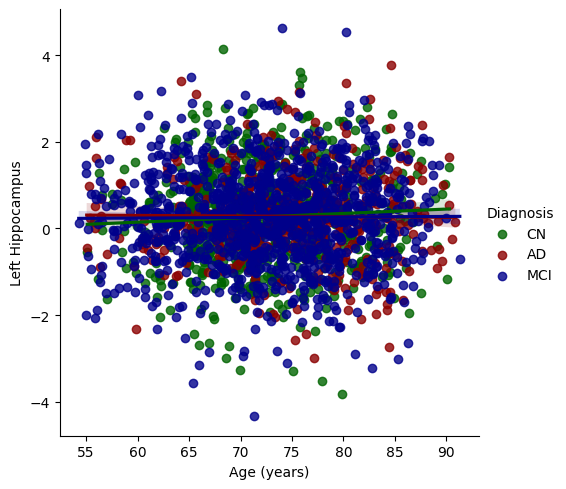

In [55]:
sns.lmplot(data=scaled_adni, x='Age', y='MUSE_Volume_107', hue='Diagnosis', palette=palette1)
plt.xlabel('Age (years)')
plt.ylabel('Left Hippocampus')

##### end diagrams

In [88]:
adni = pd.concat([cn_df_corrected, mci_df_corrected, ad_df_corrected], axis=0)
adni = adni.dropna()

adni_cn_mci = pd.concat([cn_df_corrected, mci_df_corrected], axis=0)
adni_cn_mci = adni_cn_mci.dropna()

adni_cn_ad = pd.concat([cn_df_corrected, ad_df_corrected], axis=0)
adni_cn_ad = adni_cn_ad.dropna()

adni_mci_ad = pd.concat([mci_df_corrected, ad_df_corrected], axis=0)
adni_mci_ad = adni_mci_ad.dropna()


# Separate features and labels
y_adni = adni['Diagnosis']
#age_adni = adni['Age']
X_adni = adni.drop(columns=['Age', 'Sex', 'DLICV_baseline', 'Diagnosis'], axis=1)

y_adni_cn_mci = adni_cn_mci['Diagnosis']
X_adni_cn_mci = adni_cn_mci.drop(columns=['Age', 'Sex', 'DLICV_baseline', 'Diagnosis'], axis=1)

y_adni_cn_ad = adni_cn_ad['Diagnosis']
X_adni_cn_ad = adni_cn_ad.drop(columns=['Age', 'Sex', 'DLICV_baseline', 'Diagnosis'], axis=1)

y_adni_mci_ad = adni_mci_ad['Diagnosis']
X_adni_mci_ad = adni_mci_ad.drop(columns=['Age', 'Sex', 'DLICV_baseline', 'Diagnosis'], axis=1)


uk_corrected = uk_corrected.dropna()
uk = uk_corrected.drop(columns=['Sex', 'DLICV_baseline'], axis=1)

In [89]:
#Scaling
scaler_uk  = StandardScaler()
X_uk_scaled = scaler_uk.fit_transform(uk)

# Normalize the adni dataset using the mean and SD from uk 
X_adni_scaled = scaler_uk.transform(X_adni)
X_adni_cn_mci_scaled = scaler_uk.transform(X_adni_cn_mci)
X_adni_cn_ad_scaled = scaler_uk.transform(X_adni_cn_ad)
X_adni_mci_ad_scaled = scaler_uk.transform(X_adni_mci_ad)

In [69]:
cols = X_adni.columns.tolist()
X_adni_scaled_df = pd.DataFrame(X_adni_scaled, columns=cols)

In [70]:
cols = X_adni_cn_ad.columns.tolist()
X_adni_cn_ad_scaled_df = pd.DataFrame(X_adni_cn_ad_scaled, columns=cols)

##### Vanilla Autoencoder:

In [38]:
class AnomalyDetector(Model):
    def __init__(self, l2_reg=1e-3):
        super(AnomalyDetector, self).__init__()
        # Define encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(X_uk_scaled.shape[1], activation='selu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(100, activation='selu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(64, activation='selu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(32, activation='selu', kernel_regularizer=regularizers.l2(l2_reg))])
        
        # Define decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation='selu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(100, activation='selu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(X_uk_scaled.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_reg))])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
        
autoencoder = AnomalyDetector(l2_reg=1e-3)

In [39]:
#autoencoder fit uk_biobank
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(X_uk_scaled, X_uk_scaled, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/40
204/204 [==============================] - 4s 13ms/step - loss: 1.1420 - val_loss: 0.9585
Epoch 2/40
204/204 [==============================] - 3s 15ms/step - loss: 0.8701 - val_loss: 0.8077
Epoch 3/40
204/204 [==============================] - 4s 20ms/step - loss: 0.7635 - val_loss: 0.7385
Epoch 4/40
204/204 [==============================] - 4s 19ms/step - loss: 0.7145 - val_loss: 0.7057
Epoch 5/40
204/204 [==============================] - 3s 14ms/step - loss: 0.6914 - val_loss: 0.6897
Epoch 6/40
204/204 [==============================] - 3s 15ms/step - loss: 0.6798 - val_loss: 0.6824
Epoch 7/40
204/204 [==============================] - 4s 18ms/step - loss: 0.6746 - val_loss: 0.6783
Epoch 8/40
204/204 [==============================] - 3s 16ms/step - loss: 0.6711 - val_loss: 0.6776
Epoch 9/40
204/204 [==============================] - 4s 19ms/step - loss: 0.6695 - val_loss: 0.6769
Epoch 10/40
204/204 [==============================] - 4s 18ms/step - loss: 0.6685 - val_lo

##### Variational Autoencoder:

In [40]:
#variational autoencoder implementation
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers

# Define the VAE Architecture
def build_vae(input_dim, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(100, activation='selu', kernel_regularizer=regularizers.l2(1e-3))(inputs)
    x = layers.Dense(64, activation='selu', kernel_regularizer=regularizers.l2(1e-3))(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    # Sampling Layer
    class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Sampling()([z_mean, z_log_var])

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='selu', kernel_regularizer=regularizers.l2(1e-3))(latent_inputs)
    x = layers.Dense(100, activation='selu', kernel_regularizer=regularizers.l2(1e-3))(x)
    outputs = layers.Dense(input_dim, activation='linear')(x)

    # Models
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(latent_inputs, outputs, name='decoder')
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    # Loss
    reconstruction_loss = tf.keras.losses.mean_absolute_error(inputs, outputs)
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1) * -0.5
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

    # Compile
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return vae

# Example usage:
input_dim = X_uk_scaled.shape[1]
latent_dim = 32
vae = build_vae(input_dim, latent_dim)

In [41]:
# Train the VAE
vae.fit(X_uk_scaled, X_uk_scaled, epochs=90, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/90
102/102 [==============================] - 4s 16ms/step - loss: 13.2643 - val_loss: 4.3985
Epoch 2/90
102/102 [==============================] - 1s 14ms/step - loss: 3.0339 - val_loss: 2.2813
Epoch 3/90
102/102 [==============================] - 2s 15ms/step - loss: 1.9005 - val_loss: 1.6803
Epoch 4/90
102/102 [==============================] - 2s 15ms/step - loss: 1.5026 - val_loss: 1.4143
Epoch 5/90
102/102 [==============================] - 1s 14ms/step - loss: 1.3086 - val_loss: 1.2660
Epoch 6/90
102/102 [==============================] - 1s 14ms/step - loss: 1.1964 - val_loss: 1.1775
Epoch 7/90
102/102 [==============================] - 1s 14ms/step - loss: 1.1240 - val_loss: 1.1162
Epoch 8/90
102/102 [==============================] - 1s 14ms/step - loss: 1.0743 - val_loss: 1.0721
Epoch 9/90
102/102 [==============================] - 2s 15ms/step - loss: 1.0382 - val_loss: 1.0393
Epoch 10/90
102/102 [==============================] - 2s 16ms/step - loss: 1.0114 - val_l

In [ ]:
###svm
svm_model = SVC(kernel='linear', C=1, probability=True, random_state=42)

In [42]:
def score_auc_roc(model, X, y):
    reconstructed = model.predict(X)
    res = reconstructed - X
    res[res<0] = 0
    rec_errors = np.mean(res, axis=1)
    score = roc_auc_score(y, rec_errors)
    return score

##### Results:


In [70]:
#CN vs AD
X_train, X_test, y_train, y_test = train_test_split(X_adni_cn_ad_scaled, y_adni_cn_ad, train_size=0.5, stratify=y_adni_cn_ad, random_state=42)

#svm
svm_model.fit(X_train, y_train)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr')

#autoencoder
auc1 = score_auc_roc(autoencoder, X_test, y_test)


#vae
auc2 = score_auc_roc(vae, X_test, y_test)

print("CN vs AD: ")
print(f"AUC-ROC for Vanilla Autoencoder: {auc1:4f}")
print(f"AUC-ROC for Variational Autoencoder: {auc2:4f}")
print(f"AUC-ROC for SVM: {auc_svm}")

19/19 [==============================] - 0s 3ms/step
CN vs AD: 
AUC-ROC for Vanilla Autoencoder: 0.826105
AUC-ROC for Variational Autoencoder: 0.839371
AUC-ROC for SVM: 0.9087706511175898


In [71]:
#CN vs MCI
X_train, X_test, y_train, y_test = train_test_split(X_adni_cn_mci_scaled, y_adni_cn_mci, train_size=0.5, stratify=y_adni_cn_mci, random_state=42)

#svm
svm_model.fit(X_train, y_train)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr')

#autoencoder
auc1 = score_auc_roc(autoencoder, X_test, y_test)


#vae
auc2 = score_auc_roc(vae, X_test, y_test)

print("CN vs MCI: ")
print(f"AUC-ROC for Vanilla Autoencoder: {auc1:4f}")
print(f"AUC-ROC for Variational Autoencoder: {auc2:4f}")
print(f"AUC-ROC for SVM: {auc_svm}")

30/30 [==============================] - 0s 3ms/step
CN vs MCI: 
AUC-ROC for Vanilla Autoencoder: 0.662950
AUC-ROC for Variational Autoencoder: 0.673344
AUC-ROC for SVM: 0.6924118738404453


In [79]:
#MCI vs AD
X_train, X_test, y_train, y_test = train_test_split(X_adni_mci_ad_scaled, y_adni_mci_ad, train_size=0.5, stratify=y_adni_mci_ad, random_state=42)

#svm
svm_model.fit(X_train, y_train)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr')

#autoencoder
auc1 = score_auc_roc(autoencoder, X_test, y_test)


#vae
auc2 = score_auc_roc(vae, X_test, y_test)

print("CN vs MCI: ")
print(f"AUC-ROC for Vanilla Autoencoder: {auc1:4f}")
print(f"AUC-ROC for Variational Autoencoder: {auc2:4f}")
print(f"AUC-ROC for SVM: {auc_svm}")

24/24 [==============================] - 0s 3ms/step
CN vs MCI: 
AUC-ROC for Vanilla Autoencoder: 0.740606
AUC-ROC for Variational Autoencoder: 0.735030
AUC-ROC for SVM: 0.7622034632034633


In [93]:
#CN vs MCI, AD
y_adni = adni['Diagnosis'].copy()
y_adni[y_adni==2]=1
X_train, X_test, y_train, y_test = train_test_split(X_adni_scaled, y_adni, train_size=0.5, stratify=y_adni, random_state=42)

#svm
svm_model.fit(X_train, y_train)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr')

#autoencoder
auc1 = score_auc_roc(autoencoder, X_test, y_test)


#vae
auc2 = score_auc_roc(vae, X_test, y_test)

print("CN vs MCI, AD: ")
print(f"AUC-ROC for Vanilla Autoencoder: {auc1:4f}")
print(f"AUC-ROC for Variational Autoencoder: {auc2:4f}")
print(f"AUC-ROC for SVM: {auc_svm}")

36/36 [==============================] - 0s 3ms/step
CN vs MCI, AD: 
AUC-ROC for Vanilla Autoencoder: 0.702142
AUC-ROC for Variational Autoencoder: 0.703172
AUC-ROC for SVM: 0.7521213748657357


In [94]:
#MCI vs CN, AD
y_adni = adni['Diagnosis'].copy()
y_adni[y_adni==2]=0
X_train, X_test, y_train, y_test = train_test_split(X_adni_scaled, y_adni, train_size=0.5, stratify=y_adni, random_state=42)

#svm
svm_model.fit(X_train, y_train)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr')

#autoencoder
auc1 = score_auc_roc(autoencoder, X_test, y_test)


#vae
auc2 = score_auc_roc(vae, X_test, y_test)

print("MCI vs CN, AD: ")
print(f"AUC-ROC for Vanilla Autoencoder: {auc1:4f}")
print(f"AUC-ROC for Variational Autoencoder: {auc2:4f}")
print(f"AUC-ROC for SVM: {auc_svm}")

36/36 [==============================] - 0s 4ms/step
MCI vs CN, AD: 
AUC-ROC for Vanilla Autoencoder: 0.516333
AUC-ROC for Variational Autoencoder: 0.506793
AUC-ROC for SVM: 0.5288372093023257


In [95]:
#AD vs CN, MCI
y_adni = adni['Diagnosis'].copy()
y_adni[y_adni==1]=0
y_adni[y_adni==2]=1
X_train, X_test, y_train, y_test = train_test_split(X_adni_scaled, y_adni, train_size=0.5, stratify=y_adni, random_state=42)

#svm
svm_model.fit(X_train, y_train)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr')

#autoencoder
auc1 = score_auc_roc(autoencoder, X_test, y_test)


#vae
auc2 = score_auc_roc(vae, X_test, y_test)

print("AD vs CN, MCI: ")
print(f"AUC-ROC for Vanilla Autoencoder: {auc1:4f}")
print(f"AUC-ROC for Variational Autoencoder: {auc2:4f}")
print(f"AUC-ROC for SVM: {auc_svm}")

36/36 [==============================] - 0s 3ms/step
AD vs CN, MCI: 
AUC-ROC for Vanilla Autoencoder: 0.780427
AUC-ROC for Variational Autoencoder: 0.783055
AUC-ROC for SVM: 0.791709635021737


#### Compare datasets uk and adni:

In [96]:
cn_df_corrected = cn_df_corrected.drop(['Age', 'Sex','DLICV_baseline', 'Diagnosis'], axis=1)
cn_df_corrected = cn_df_corrected.dropna()

ad_df_corrected = ad_df_corrected.drop(['Age', 'Sex','DLICV_baseline', 'Diagnosis'], axis=1)
ad_df_corrected = ad_df_corrected.dropna()

mci_df_corrected = mci_df_corrected.drop(['Age', 'Sex','DLICV_baseline', 'Diagnosis'], axis=1)
mci_df_corrected = mci_df_corrected.dropna()

In [97]:
x_cn_df_test = scaler_uk.transform(cn_df_corrected)
x_mci_df_test = scaler_uk.transform(mci_df_corrected)
x_ad_df_test = scaler_uk.transform(ad_df_corrected)

##### ΑΕ:

In [98]:
#cn
column_list = cn_df_corrected.columns.tolist()
pred_cn_x_bad = autoencoder.predict(x_cn_df_test)
#pred_cn_x_bad = vae.predict(x_cn_df_test)
cn_res = pred_cn_x_bad - x_cn_df_test
cn_res[cn_res<0] = 0
cn_res_df = pd.DataFrame(cn_res, columns=column_list)
cn_res_df['Diagnosis'] = 'CN'

25/25 [==============================] - 0s 4ms/step


In [99]:
#mci
column_list = mci_df_corrected.columns.tolist()
pred_mci_x_bad = autoencoder.predict(x_mci_df_test)
#pred_mci_x_bad = vae.predict(x_mci_df_test)
mci_res = pred_mci_x_bad - x_mci_df_test
mci_res[mci_res<0] = 0
mci_res_df = pd.DataFrame(mci_res, columns=column_list)
mci_res_df['Diagnosis'] = 'MCI'

35/35 [==============================] - 0s 4ms/step


In [100]:
#ad
column_list = ad_df_corrected.columns.tolist()
pred_ad_x_bad = autoencoder.predict(x_ad_df_test)\
#pred_ad_x_bad = vae.predict(x_ad_df_test)
ad_res = pred_ad_x_bad - x_ad_df_test
ad_res[ad_res<0] = 0
ad_res_df = pd.DataFrame(ad_res, columns=column_list)
ad_res_df['Diagnosis'] = 'AD'

14/14 [==============================] - 0s 5ms/step


In [101]:
#concat residuals
column_list.append('Diagnosis')
concat_res = pd.concat([cn_res_df, mci_res_df, ad_res_df], axis=0)
concat_res

,MUSE_Volume_105,MUSE_Volume_137,MUSE_Volume_147,MUSE_Volume_179,MUSE_Volume_104,MUSE_Volume_136,MUSE_Volume_146,MUSE_Volume_178,MUSE_Volume_103,MUSE_Volume_173,...,MUSE_Volume_117,MUSE_Volume_171,MUSE_Volume_116,MUSE_Volume_170,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,Diagnosis
0,4.164483,0.000000,1.053857,0.479466,0.0,0.544051,0.563262,1.456925,0.265613,0.000000,...,1.042104,0.509547,0.000000,0.000000,0.000000,0.043363,0.224285,1.333317,1.080076,CN
1,1.039670,0.000000,0.000000,0.000000,0.0,0.953579,0.000000,1.127743,1.588083,2.344623,...,0.000000,0.000000,0.000000,0.000000,0.230496,0.794621,1.668883,2.677109,1.549900,CN
2,1.097875,0.000000,0.000000,0.670638,0.0,0.770451,0.219863,0.818472,0.000000,0.979073,...,0.620394,0.070297,0.000000,0.000000,0.000000,0.288081,0.732617,1.218409,0.000000,CN
3,2.486443,0.000000,0.111447,0.702611,0.0,1.250572,0.236059,0.055156,0.173813,0.922951,...,1.370716,0.000000,0.000000,0.632429,0.000000,0.277883,0.000000,1.308678,0.000000,CN
4,2.783580,0.000000,0.993798,0.434287,0.0,0.979732,1.111576,1.052920,0.336648,1.136411,...,0.000000,0.429397,0.000000,0.313977,0.630909,0.892613,0.772844,0.575082,0.000000,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,1.502596,0.000000,0.000000,1.011159,0.0,2.219090,0.000000,1.761671,0.333611,2.275059,...,2.331188,1.390002,0.000000,0.153530,0.556900,0.265987,1.752937,0.734161,0.207640,AD
416,0.000000,0.836996,0.000000,0.308485,0.0,0.753043,0.000000,1.916463,0.389115,2.367645,...,1.600702,0.254811,0.402744,0.089953,0.000000,0.543311,2.255155,1.995402,0.000000,AD
417,1.939249,0.000000,0.361705,0.367682,0.0,1.907398,0.795115,0.953727,1.085450,1.275467,...,2.395081,1.570474,0.000000,0.000000,0.000000,0.000000,1.028290,1.461094,0.000000,AD
418,1.915204,0.462301,0.775100,1.322717,0.0,1.623866,0.000000,1.750574,1.294736,1.552274,...,0.000000,0.792665,0.000000,0.000000,0.248308,0.887762,1.751471,1.021940,0.000000,AD


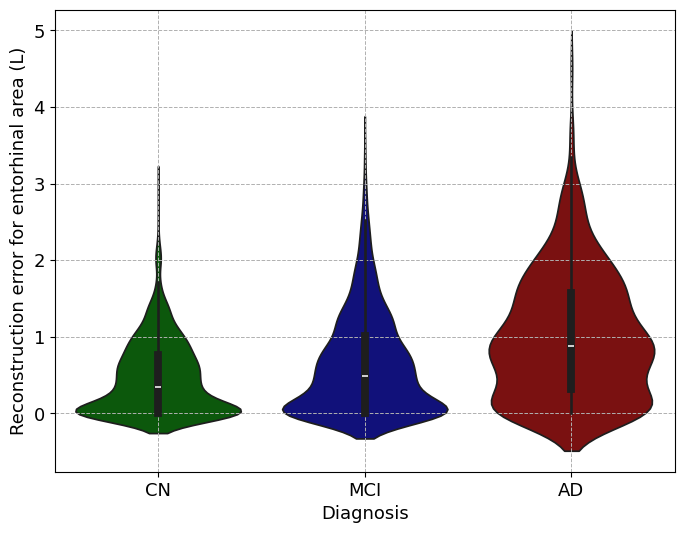

In [108]:
#violinplot entorhinal
my_pal_sex = palette1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a violinplot
sns.violinplot(y='MUSE_Volume_117', x='Diagnosis', data=concat_res, hue='Diagnosis', palette=palette1, ax=ax)


# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.rcParams.update({'font.size': 13})
plt.ylabel('Reconstruction error for entorhinal area (L)')
# Show the plot
plt.show()

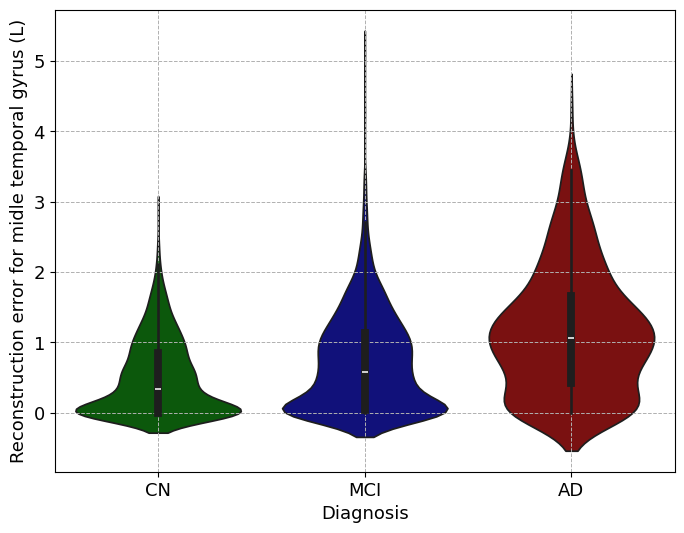

In [109]:
#violinplot midle temporal gyrus
my_pal_sex = palette1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a violinplot
sns.violinplot(y='MUSE_Volume_155', x='Diagnosis', data=concat_res, hue='Diagnosis', palette=palette1, ax=ax)


# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.rcParams.update({'font.size': 12})
plt.ylabel('Reconstruction error for midle temporal gyrus (L)')
# Show the plot
plt.show()

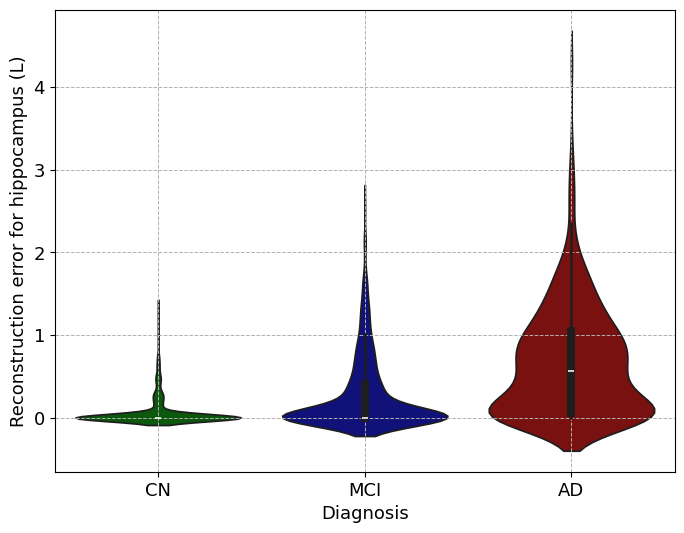

In [115]:
#violinplot hippocampus
my_pal_sex = palette1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a violinplot
sns.violinplot(y='MUSE_Volume_48', x='Diagnosis', data=concat_res, hue='Diagnosis', palette=my_pal_sex, ax=ax)


# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
#plt.rcParams.update({'font.size': 13})
plt.ylabel('Reconstruction error for hippocampus (L)')
# Show the plot
plt.show()

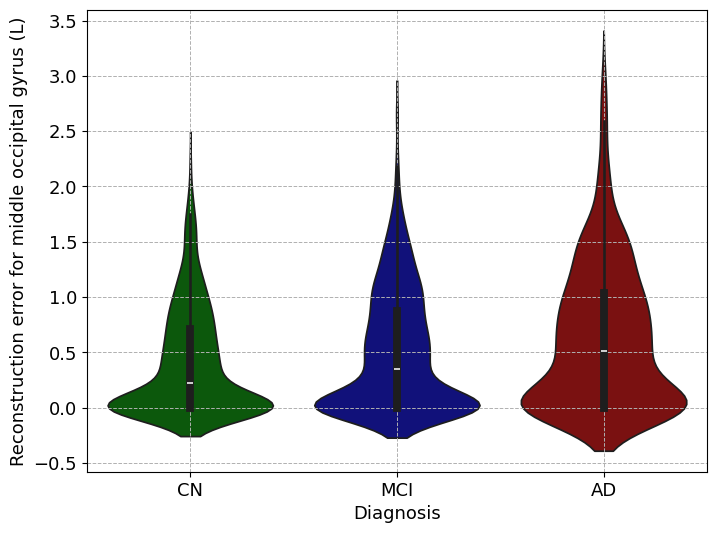

In [116]:
#violinplot middle occipital gyrus
my_pal_sex = palette1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a violinplot
sns.violinplot(y='MUSE_Volume_145', x='Diagnosis', data=concat_res, hue='Diagnosis', palette=my_pal_sex, ax=ax)


# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
#plt.rcParams.update({'font.size': 14})
plt.ylabel('Reconstruction error for middle occipital gyrus (L)')
# Show the plot
plt.show()

##### VAE:

In [117]:
#cn
column_list = cn_df_corrected.columns.tolist()
pred_cn_x_bad = vae.predict(x_cn_df_test)
cn_res = pred_cn_x_bad - x_cn_df_test
cn_res[cn_res<0] = 0
cn_res_df = pd.DataFrame(cn_res, columns=column_list)
cn_res_df['Diagnosis'] = 'CN'

25/25 [==============================] - 0s 4ms/step


In [118]:
#mci
column_list = mci_df_corrected.columns.tolist()
pred_mci_x_bad = vae.predict(x_mci_df_test)
mci_res = pred_mci_x_bad - x_mci_df_test
mci_res[mci_res<0] = 0
mci_res_df = pd.DataFrame(mci_res, columns=column_list)
mci_res_df['Diagnosis'] = 'MCI'

35/35 [==============================] - 0s 4ms/step


In [119]:
#ad
column_list = ad_df_corrected.columns.tolist()
pred_ad_x_bad = vae.predict(x_ad_df_test)
ad_res = pred_ad_x_bad - x_ad_df_test
ad_res[ad_res<0] = 0
ad_res_df = pd.DataFrame(ad_res, columns=column_list)
ad_res_df['Diagnosis'] = 'AD'

14/14 [==============================] - 0s 4ms/step


In [120]:
#concat residuals
column_list.append('Diagnosis')
concat_res = pd.concat([cn_res_df, mci_res_df, ad_res_df], axis=0)
concat_res

,MUSE_Volume_105,MUSE_Volume_137,MUSE_Volume_147,MUSE_Volume_179,MUSE_Volume_104,MUSE_Volume_136,MUSE_Volume_146,MUSE_Volume_178,MUSE_Volume_103,MUSE_Volume_173,...,MUSE_Volume_117,MUSE_Volume_171,MUSE_Volume_116,MUSE_Volume_170,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,Diagnosis
0,4.741185,1.326840,2.345061,1.802784,0.086454,1.876674,1.691662,2.764891,1.688454,0.447189,...,1.246969,1.625226,0.000000,0.337850,0.000000,0.000000,0.130656,1.428949,0.713503,CN
1,0.517307,0.000000,1.016747,0.522481,0.000000,2.155354,0.000000,1.988545,3.162520,3.560584,...,0.000000,0.000000,0.000000,0.000000,0.997139,1.328939,1.879881,3.045739,1.923670,CN
2,1.491021,0.488511,0.774272,2.097923,0.000000,1.365482,1.598588,2.058343,1.658609,2.597622,...,1.636639,1.240797,0.288486,0.000000,0.000000,0.376616,0.808813,1.132042,0.000000,CN
3,2.497895,0.117150,1.019859,2.566790,0.000000,1.261530,1.066903,1.775962,1.856244,1.922764,...,2.922238,1.697161,1.291103,2.267577,0.447537,0.663635,0.000000,1.387778,0.000000,CN
4,3.321124,0.350262,2.544746,0.906200,0.000000,1.782309,2.721185,1.732389,2.167756,2.388334,...,0.110085,1.012075,0.000000,0.815302,1.722022,1.819559,1.199042,1.469224,0.000000,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,2.020170,0.662865,0.000000,1.944872,0.681481,2.907576,0.895894,2.592736,2.003142,3.910959,...,3.670232,3.418994,0.000000,2.087181,1.357589,0.972537,1.552694,0.863520,0.571111,AD
416,0.081874,1.884416,0.679305,1.296987,0.053560,1.379103,0.862815,2.748112,1.933474,3.956625,...,2.717774,1.677399,1.627223,1.510779,0.407631,1.166217,2.213865,2.043165,0.000000,AD
417,2.325411,1.134143,1.231500,1.187969,0.575330,3.089335,1.998755,1.633840,2.617536,2.470841,...,3.547125,3.065940,0.000000,1.305237,0.000000,0.000000,0.427630,1.097688,0.000000,AD
418,2.200134,1.611228,1.658584,2.895774,0.425151,1.939792,1.041726,3.293251,3.401724,3.336603,...,0.468435,1.602334,0.000000,0.440697,1.347162,1.907396,2.432180,1.394512,0.000000,AD


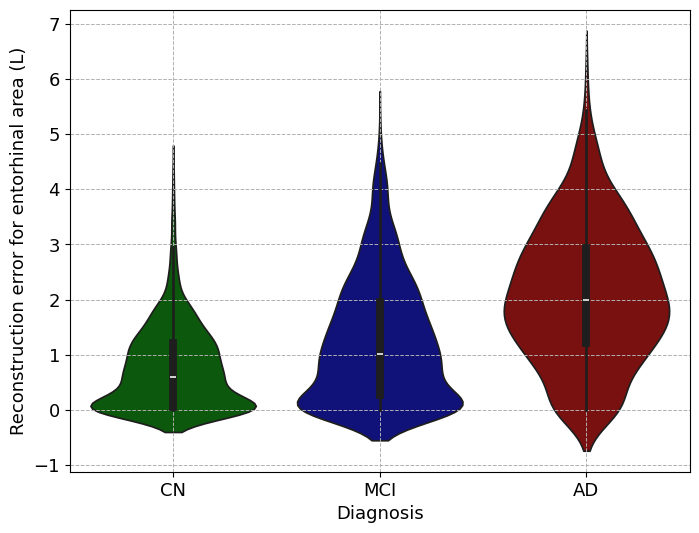

In [121]:
#violinplot entorhinal
my_pal_sex = palette1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a violinplot
sns.violinplot(y='MUSE_Volume_117', x='Diagnosis', data=concat_res, hue='Diagnosis', palette=palette1, ax=ax)


# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.rcParams.update({'font.size': 13})
plt.ylabel('Reconstruction error for entorhinal area (L)')
# Show the plot
plt.show()

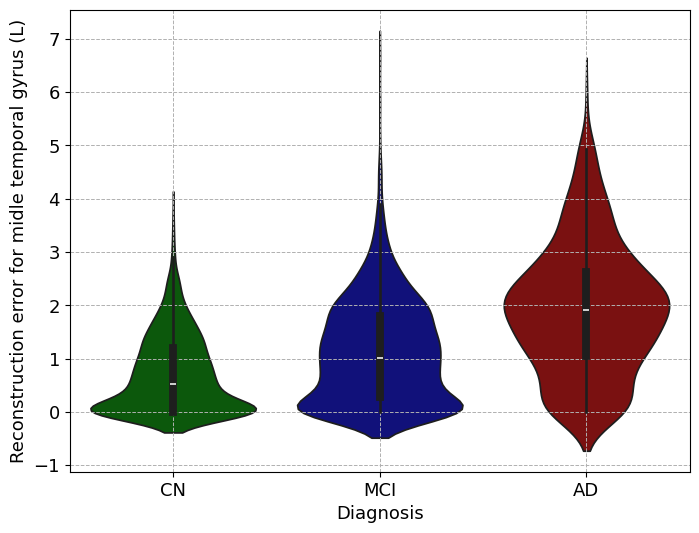

In [122]:
#violinplot midle temporal gyrus
my_pal_sex = palette1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a violinplot
sns.violinplot(y='MUSE_Volume_155', x='Diagnosis', data=concat_res, hue='Diagnosis', palette=palette1, ax=ax)


# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.rcParams.update({'font.size': 12})
plt.ylabel('Reconstruction error for midle temporal gyrus (L)')
# Show the plot
plt.show()

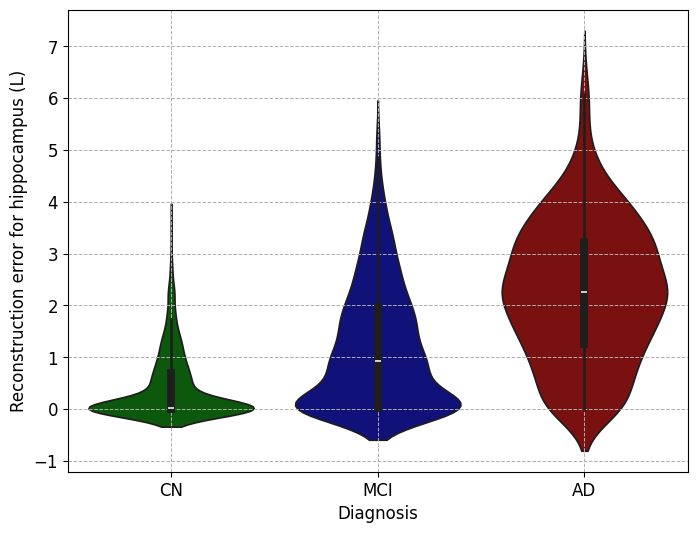

In [123]:
#violinplot hippocampus
my_pal_sex = palette1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a violinplot
sns.violinplot(y='MUSE_Volume_48', x='Diagnosis', data=concat_res, hue='Diagnosis', palette=my_pal_sex, ax=ax)


# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
#plt.rcParams.update({'font.size': 13})
plt.ylabel('Reconstruction error for hippocampus (L)')
# Show the plot
plt.show()

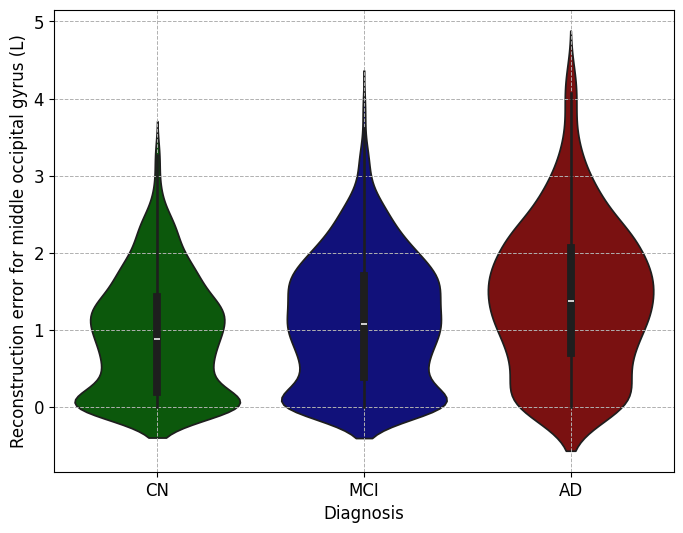

In [124]:
#violinplot middle occipital gyrus
my_pal_sex = palette1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Create a violinplot
sns.violinplot(y='MUSE_Volume_145', x='Diagnosis', data=concat_res, hue='Diagnosis', palette=my_pal_sex, ax=ax)


# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
#plt.rcParams.update({'font.size': 14})
plt.ylabel('Reconstruction error for middle occipital gyrus (L)')
# Show the plot
plt.show()